<a href="https://colab.research.google.com/github/arindamroy-eng/Pytorch-and-other-ML-Experiments/blob/main/Transfer_Learning_ALEX_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [5]:
!git clone https://github.com/jaddoescad/ants-bees-dataset.git

Cloning into 'ants-bees-dataset'...
remote: Enumerating objects: 408, done.
remote: Total 408 (delta 0), reused 0 (delta 0), pack-reused 408 (from 1)
Receiving objects: 100% (408/408), 45.03 MiB | 22.94 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [32]:
!ls ants-bees-dataset/train/

ants  bees


In [9]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

training_dataset = torchvision.datasets.ImageFolder(root="ants-bees-dataset/train/", transform=transform_train)
training_loader = DataLoader(dataset=training_dataset, batch_size=20, shuffle=True)

validation_dataset = torchvision.datasets.ImageFolder(root="ants-bees-dataset/val/", transform=transform)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=20, shuffle=False)





In [10]:
print(len(training_dataset))
print(len(validation_dataset))

244
153


In [11]:
def im_convert(tensor):
  image = tensor.to("cpu").clone().detach().numpy()
  image = image.squeeze()
  # Swap (1,28,28) to (28, 28, 1)
  image = image.transpose(1,2,0)
  #print(image)
  #normalize. Image data ranges form 0-255. Convert to range -1 to 1
  image = image * np.array((0.5, 0.5,0.5)) + np.array((0.5, 0.5,0.5))
  # limit all the values between 0 and 1
  image = image.clip(0,1)

  return image

In [12]:
classes = ('ant', 'bees')

torch.Size([3, 224, 224]) tensor(1)


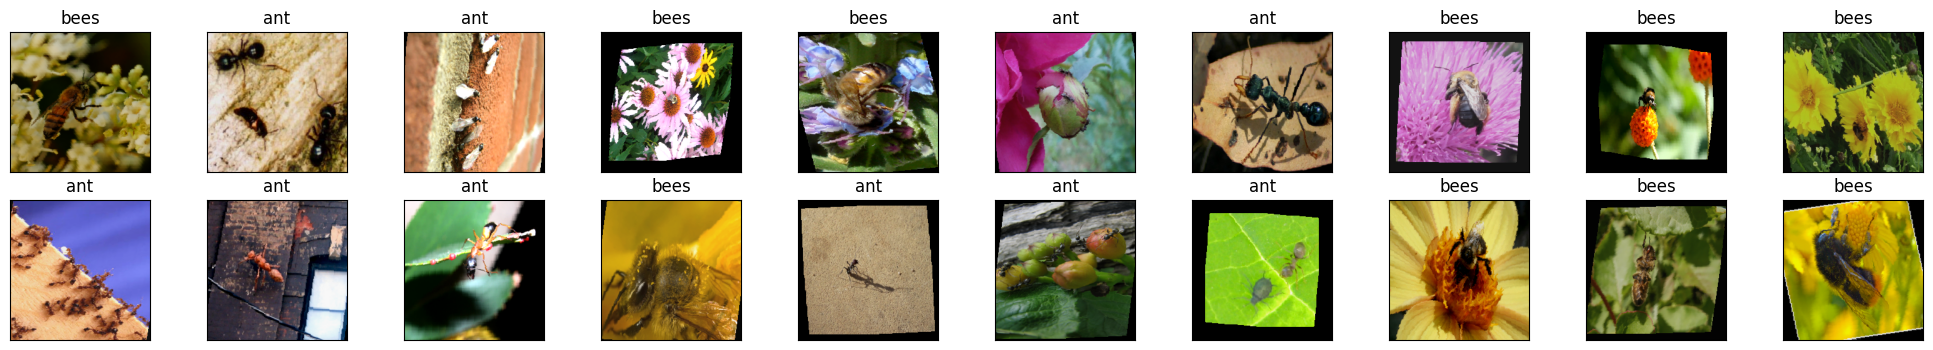

In [13]:
# Lets show some samples from the the training dataset
dataiter = iter(training_loader)
images, labels = next(dataiter)
print(images[0].size(), labels[0])


fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [47]:
model = models.alexnet(pretrained=True)
#model = models.vgg16(pretrained=True)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 193MB/s]


In [48]:
for param in model.features.parameters():
  param.requires_grad = False


In [49]:
import torch.nn as nn
# The default model contains lots of more classes
# print(model)
# Linear(in_features=4096, out_features=1000, bias=True)
# We need to set the output to 2 instead of 1000
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)

# (6): Linear(in_features=4096, out_features=2, bias=True)
#print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [50]:
# Now lets train with avlbl data
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)



In [53]:
epochs = 10
running_loss_history = []
running_corrects_history = []

val_running_loss_history = []
val_running_loss_corrects = []

for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    # No need to flatten in the next line for CNN
    #inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.data).cpu()
    running_loss += loss.item()
  else:
    with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
          val_inputs = val_inputs.to(device)
          val_labels = val_labels.to(device)
          #val_inputs = val_inputs.view(inputs.shape[0], -1)
          val_outputs = model(val_inputs)
          val_loss = criterion(val_outputs, val_labels)

          _, val_preds = torch.max(val_outputs, 1)
          val_running_loss += val_loss.item()
          val_running_corrects += torch.sum(val_preds == val_labels.data).cpu()

    epoch_loss = running_loss / len(training_loader.dataset)
    epoch_accuracy = running_corrects.float()/len(training_loader.dataset)
    running_corrects_history.append(epoch_accuracy)
    running_loss_history.append(epoch_loss)
    #print(f"training loss:{epoch_loss:.4f}, {epoch_accuracy.item():.4f}")
    val_epoch_loss = val_running_loss / len(validation_loader.dataset)
    val_epoch_accuracy = val_running_corrects.float()/len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_loss_corrects.append(val_epoch_accuracy)

    print(f"Epoch count:{e}")
    print(f"training loss:{epoch_loss:.4f}, accuracy:{epoch_accuracy.item():.4f}")
    print(f"validation loss:{val_epoch_loss:.4f}, accuracy:{val_epoch_accuracy.item():.4f}")


Epoch count:0
training loss:0.0302, accuracy:0.7213
validation loss:0.0192, accuracy:0.8627
Epoch count:1
training loss:0.0139, accuracy:0.8852
validation loss:0.0167, accuracy:0.8889
Epoch count:2
training loss:0.0138, accuracy:0.9262
validation loss:0.0156, accuracy:0.9020
Epoch count:3
training loss:0.0074, accuracy:0.9426
validation loss:0.0142, accuracy:0.8824
Epoch count:4
training loss:0.0050, accuracy:0.9631
validation loss:0.0203, accuracy:0.8758
Epoch count:5
training loss:0.0064, accuracy:0.9467
validation loss:0.0184, accuracy:0.8889
Epoch count:6
training loss:0.0047, accuracy:0.9631
validation loss:0.0172, accuracy:0.9085
Epoch count:7
training loss:0.0050, accuracy:0.9795
validation loss:0.0198, accuracy:0.9281
Epoch count:8
training loss:0.0042, accuracy:0.9672
validation loss:0.0235, accuracy:0.8693
Epoch count:9
training loss:0.0037, accuracy:0.9672
validation loss:0.0193, accuracy:0.8954


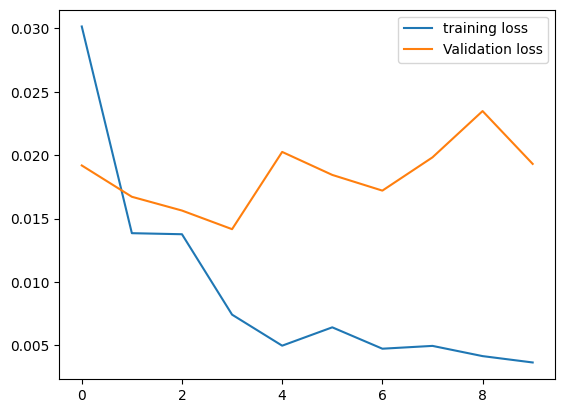

In [54]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='Validation loss')
plt.legend()

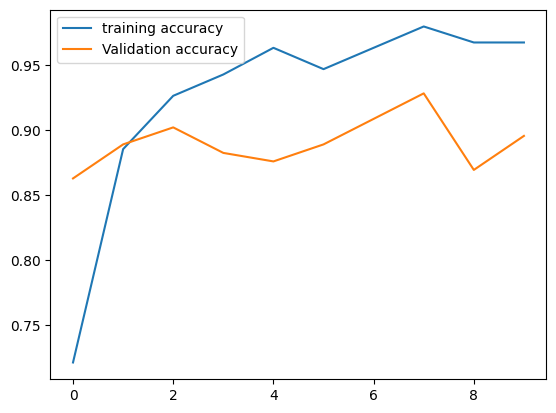

In [55]:
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(val_running_loss_corrects, label = 'Validation accuracy')
plt.legend()

(600, 600)


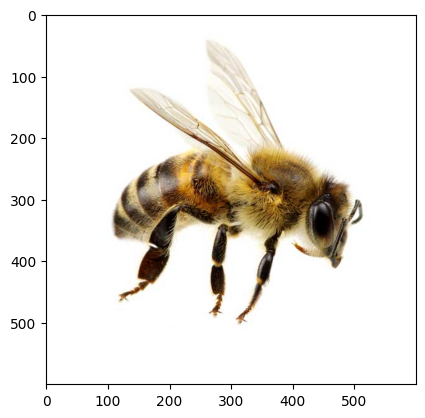

In [37]:
import requests
from PIL import Image, ImageOps

url = 'https://www.flapest.com/wp-content/uploads/2020/12/honey-bee.jpg'
response = requests.get(url, stream = True)
#print(response)
img = Image.open(response.raw)
plt.imshow(img)
print(img.size)



torch.Size([3, 224, 224])


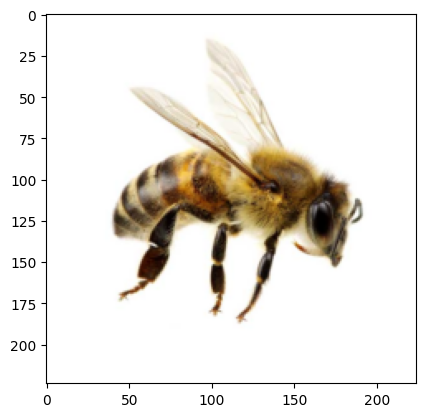

In [38]:
img = transform(img)
print(img.shape)
plt.imshow(im_convert(img))


In [56]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

bees


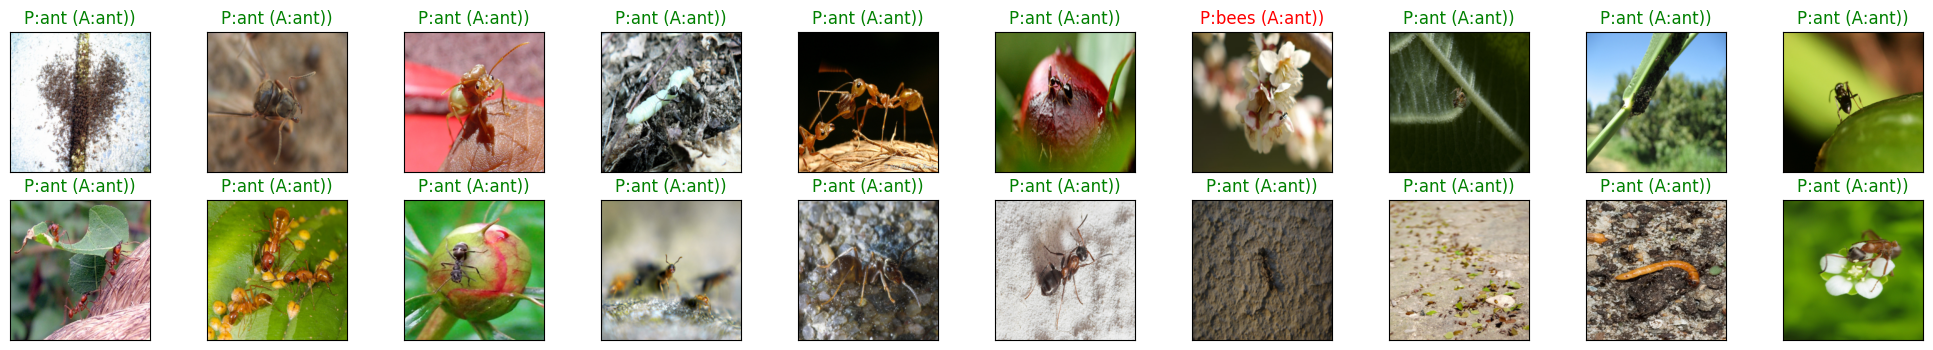

In [57]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)
#images_ = images.view(images.shape[0], -1)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))

rows = 2
total = 20
cols = int(total / rows)
for idx in np.arange(total):
  ax = fig.add_subplot(rows, cols, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("P:{} (A:{}))".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx] == labels[idx] else "red"))


In [58]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
features.0.weight 	 torch.Size([64, 3, 11, 11])
features.0.bias 	 torch.Size([64])
features.3.weight 	 torch.Size([192, 64, 5, 5])
features.3.bias 	 torch.Size([192])
features.6.weight 	 torch.Size([384, 192, 3, 3])
features.6.bias 	 torch.Size([384])
features.8.weight 	 torch.Size([256, 384, 3, 3])
features.8.bias 	 torch.Size([256])
features.10.weight 	 torch.Size([256, 256, 3, 3])
features.10.bias 	 torch.Size([256])
classifier.1.weight 	 torch.Size([4096, 9216])
classifier.1.bias 	 torch.Size([4096])
classifier.4.weight 	 torch.Size([4096, 4096])
classifier.4.bias 	 torch.Size([4096])
classifier.6.weight 	 torch.Size([2, 4096])
classifier.6.bias 	 torch.Size([2])
Optimizer's state_dict:
state 	 {10: {'step': tensor(130.), 'exp_avg': tensor([[ 1.5724e-05,  4.7462e-07, -1.7737e-06,  ..., -1.4949e-06,
         -2.5391e-06, -2.7053e-06],
        [-2.5923e-06,  2.9142e-05,  2.8794e-05,  ..., -9.7688e-06,
          6.0239e-09,  3.5074e-07],
        [ 0.0000e+00,  0.00